In [35]:
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout#, RandomFlip, RandomRotation
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [36]:
# helper function that builds df for kaggle contest
def kaggle_submission(model):
    test = pd.read_csv('./data/fashion-mnist_test.csv').values / 255
    (
        pd.DataFrame(
            {'ImageId': range(1, len(test)+1), 
            'Label': model.predict(test.reshape((len(test), *[int(test.shape[1]**0.5)]*2, 1)), verbose=0).argmax(1)}
        )
        .to_csv('./data/submission.csv', index=False)
    )

# helper function to plot results
def plotter(axs, result, cv=1):
    for i, v in enumerate(['loss', 'accuracy']):
        for j in range(cv):
            axs[i].plot(result[f"{v}"], label=f"Training {v.title()}")
            axs[i].plot(result[f"val_{v}"], label=f"Validation {v.title()}")

        axs[i].set_title(f'{v.title()} Across Epochs', fontsize=20)
        axs[i].set_ylabel(f"{v.title()}", fontsize=15)
        axs[i].set_xlabel("Number of Epochs", fontsize=15)
        axs[i].legend(fontsize=10);

In [37]:
def read_dataset():
    
    # read data
    X = pd.read_csv("./data/fashion-mnist_train.csv")
    
    # separate y from X
    y = X.pop('label')

    # reshape the data into 4d numpy array where 
    # the first dimension is the number of samples and the remaining dimensions are of image data
    X = X.values.reshape((len(X), *[int(X.shape[1]**0.5)]*2, 1))
    
    return X, y


def preprocessing(X, y):
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2022, stratify=y)
    
    # normalize data
    X_train = X_train / 255
    X_test  = X_test / 255
    
    global image_shape
    image_shape = X_train.shape[1:]
    
    return (X_train, y_train), (X_test, y_test)

In [38]:
def build_model():

    num_filters = 32
    model = Sequential()

    model.add(Conv2D(num_filters, 3, activation='relu', kernel_regularizer=l2(0.1), input_shape=image_shape))
    model.add(Conv2D(num_filters, 3, activation='relu', kernel_regularizer=l2(0.1)))
    model.add(MaxPooling2D(2))
#     model.add(Conv2D(num_filters*2, 3, activation='relu', kernel_regularizer=l2(0.1)))
#     model.add(Conv2D(num_filters*2, 3, activation='relu', kernel_regularizer=l2(0.1)))
#     model.add(MaxPooling2D(2))
#     model.add(Conv2D(num_filters*3, 3, activation='relu', kernel_regularizer=l2(0.1)))
#     model.add(Conv2D(num_filters*3, 3, activation='relu', kernel_regularizer=l2(0.1)))
    model.add(Flatten())
    model.add(BatchNormalization())
#     model.add(Dense(128, use_bias=False, kernel_regularizer=l2(0.1)))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
    model.add(Dense(64, use_bias=False, kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(32, use_bias=False, kernel_regularizer=l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(10, activation='softmax'))

    return model

In [46]:
def fit_model(model, train_data, val_data):
    
    batch = 128
    epochs = 50

#     lr_plateau = ReduceLROnPlateau()
#     early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
#     check_point = ModelCheckpoint(filepath='./data/best_model.h5', save_best_only=True)
    
    history = model.fit(
        *train_data, 
        validation_data=val_data, 
        epochs=epochs, 
        batch_size=batch,
#        callbacks = [lr_plateau, check_point, early_stopping]
    )
    
    return model, history

In [47]:
#(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [48]:
X, y = read_dataset()
train_data, val_data = preprocessing(X, y)

In [49]:
num_2_item_map = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 
                  3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 
                  7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

The first image is Pullover:


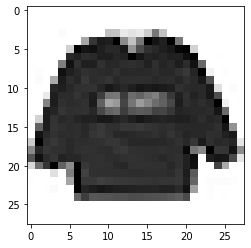

In [50]:
print(f'The first image is {num_2_item_map[y[0]]}:')
plt.imshow(X[0].reshape(28,28,1), 'binary');

In [51]:
model = build_model()

In [52]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 27, 27, 32)        160       
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 64)        32832     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 11, 11, 32)        8224      
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 64)          32832     
                                                      

In [54]:
model, history = fit_model(model, train_data, val_data)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
plotter(axs, history.history)
fig.tight_layout();